# MACS 40300: Problem Set #2 
### By: Jesús Pacheco Vera


## 1. Health claim amounts and the GB family of distributions

In [782]:
%reset
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [783]:
#Import the txt file
url_claims = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS2/clms.txt')
response1 = requests.get(url_claims,allow_redirects=True)

open('clms.txt', 'wb').write(response1.content)
claims = np.loadtxt("clms.txt")
claims

array([361.65, 123.04, 541.77, ...,  97.43, 186.88, 119.19])

#### Part a)

In [784]:
print('Mean:' , np.mean(claims))
print('Median:' , np.median(claims))
print('Maximum:' , np.max(claims))
print('Minimum:' , np.min(claims))
print('Standard deviation:' , np.std(claims))

Mean: 720.2779753272437
Median: 172.21
Maximum: 227967.25
Minimum: 0.01
Standard deviation: 3972.663756393663


Text(0.5, 1.0, 'Histogram of monthly claims')

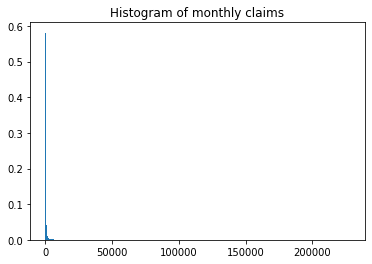

In [785]:
#Compute weights so we can have frequencies
weights = (1 / claims.shape[0]) * np.ones_like(claims)
plt.hist(claims, 1000, weights=weights)
plt.title('Histogram of monthly claims')

Text(0.5, 1.0, 'Histogram of monthly claims (less or equal to 800 usd)')

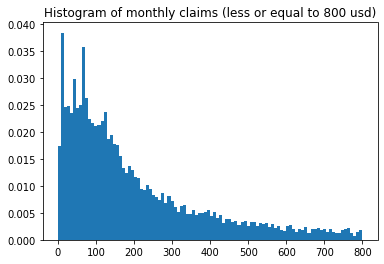

In [786]:
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')

Since we have some huge outliers in the data, the first histogram is not very informative of the distribution. The second one is much more informative of the part of the distribution that displays the biggest part of the data. 

#### Part b) Fitting a gamma distribution

In [787]:
import math
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = (1 / ((beta ** alpha) *  math.gamma(alpha))) * (xvals ** (alpha - 1)) * (np.exp(-(xvals/beta)))
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

In [788]:
#The function of the log likelihood
def log_lik_gamma(xvals, alpha, beta):
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_vals = ln_pdf_vals.sum()
    return log_lik_vals

In [789]:
#Critieron function
def crit(params, *args):
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [790]:
#Minimization function
import scipy.optimize as opt

beta_init = np.std(claims)**2 / np.mean(claims)
#beta_init = 80
alpha_init = np.mean(claims)/beta_init
#alpha_init = .7
params_init=np.array([alpha_init, beta_init])
ga_args = (claims)

results = opt.minimize(crit, params_init, args=(ga_args), method='TNC', bounds=((1e-10, None), (1e-10, None)), tol=1e-12)

alpha_MLE, beta_MLE = results.x
print('alpha_MLE =', alpha_MLE, ', beta_MLE =', beta_MLE)
print('Log-likelihood =',log_lik_gamma(claims, alpha_MLE, beta_MLE))
#print('Log-likelihood =',log_lik_gamma(claims, .7, 80))

alpha_MLE = 0.557068464615839 , beta_MLE = 998.402556156263
Log-likelihood = -77001.36877603488


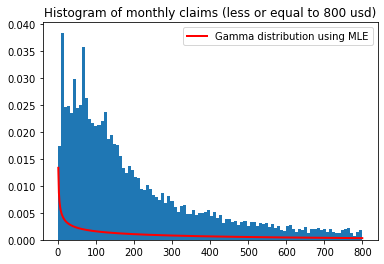

In [930]:
#The two plots together: 
dist_pts = np.linspace(1, 800, 500)
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')
plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_MLE, beta_MLE),
         linewidth=2, color='r', label='Gamma distribution using MLE')
plt.legend(loc='upper right')

My MLE estimates do not seem like good fit of the data. I tried to debug something but was unable to find an error. I manually tried to find better estimates for alpha and beta, .7 and 8 respectively seemed to better fit the histogram but the log_likelihood is less.  
I tried to do a 3D graph to see if it was finding local maxima, but I ran into coding errors, I tried to initialize on `params_init = .7 and 8` but the results is basically the same, so the optimization is probably not finding local maxima. 

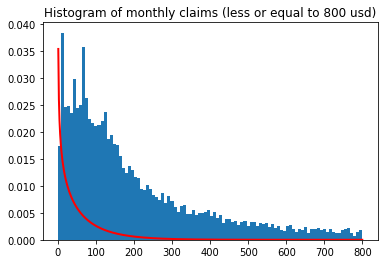

In [931]:
#.7 and 80 seem better fit, for example: 
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')
plt.plot(dist_pts, gamma_pdf(dist_pts, .7, 80),
         linewidth=2, color='r')

#### Part c) Fitting a Generalized Gamma distribution

In [793]:
#Generalized gama function
def ggamma_pdf(xvals, alpha, beta, m):
    pdf_vals_gg = (m / ((beta ** alpha) * math.gamma(alpha/m))) * (xvals ** (alpha - 1)) * (np.exp(-(xvals/beta)**m))
    pdf_vals_gg[pdf_vals_gg < 1e-10] = 1e-10
    return pdf_vals_gg

In [794]:
#The function of the log likelihood
def log_lik_ggamma(xvals, alpha, beta, m):
    pdf_vals_gg = ggamma_pdf(xvals, alpha, beta,m)
    ln_pdf_vals_gg = np.log(pdf_vals_gg)
    log_lik_vals_gg = ln_pdf_vals_gg.sum()
    return log_lik_vals_gg

In [795]:
#Critieron function
def crit_gg(params, *args):
    alpha, beta, m = params
    xvals = args
    log_lik_val_gg = log_lik_ggamma(xvals, alpha, beta, m)
    neg_log_lik_val_gg = -log_lik_val_gg
    
    return neg_log_lik_val_gg

In [796]:
#Minimization function
params_init_gg=np.array([alpha_MLE, beta_MLE, 1])
gg_args = (claims)

results_gg = opt.minimize(
    crit_gg, params_init_gg, args=(gg_args), method='TNC', bounds=((1e-10, None), (1e-10, None),(None, None)))

alpha_gg, beta_gg, m_gg = results_gg.x
print('alpha GG:', alpha_gg)
print('beta GG:', beta_gg) 
print('m GG:', m_gg)    
print('Log-likelihood GG: ', log_lik_ggamma(claims, alpha_gg, beta_gg, m_gg))

alpha GG: 0.9487399866616659
beta GG: 58.58905942550018
m GG: 0.44990898275105207
Log-likelihood GG:  -75525.71126798438


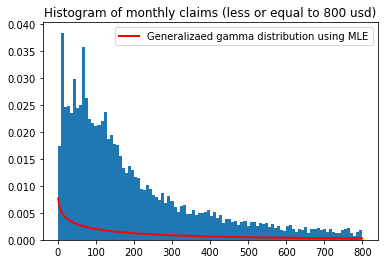

In [932]:
#The two plots together: 
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')
plt.plot(dist_pts, ggamma_pdf(dist_pts, alpha_gg, beta_gg, m_gg),
         linewidth=2, color='r', label='Generalizaed gamma distribution using MLE')
plt.legend(loc='upper right')

As in part b), the estimation is not fitting the data very well. Actually, both estimation (GA and GG) are quite similiar to each other, which I think makes sense. Here's the graph:

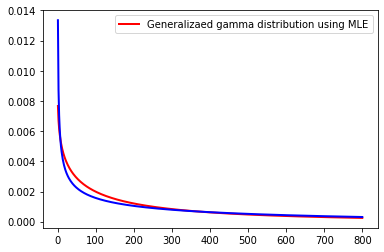

In [934]:
#The seem to be almost the same distribution
plt.plot(dist_pts, ggamma_pdf(dist_pts, alpha_gg, beta_gg, m_gg),
         linewidth=2, color='r', label='Generalizaed gamma distribution using MLE')
plt.legend(loc='upper right')
plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_MLE, beta_MLE),
         linewidth=2, color='b', label='Gamma distribution using MLE')

#### Part d) Fitting a Generalized Beta 2 distribution

In [799]:
#Generalized beta 2 function
import scipy.special as spc

def gb2_pdf(xvals, a, b, p, q):
    pdf_vals_gb2 = (a*(xvals**(a*p-1))) / ((b**(a*p)) * (spc.beta(p,q)) * ((1+(xvals/b)**a))**(p+q))
    #pdf_vals_gb2[pdf_vals_gb2 < 1e-10] = 1e-10
    return pdf_vals_gb2

In [800]:
#Testing my pdf function:
q_init = 10000
gb2_pdf(claims, m_gg, q_init**(1/m_gg), alpha_gg/m_gg, q_init)

array([2.26377876e-07, 5.49386481e-05, 1.32227643e-08, ...,
       1.32478970e-04, 8.87181794e-06, 6.22741424e-05])

In [801]:
#The function of the log likelihood
def log_lik_gb2(xvals, a, b, p, q):
    pdf_vals_gb2 = gb2_pdf(xvals, a, b, p, q)
    ln_pdf_vals_gb2 = np.log(pdf_vals_gb2)
    log_lik_vals_gb2 = ln_pdf_vals_gb2.sum()
    return log_lik_vals_gb2

In [802]:
#Critieron function
def crit_gb2(params, *args):
    a, b, p, q = params
    xvals = args
    log_lik_val_gb2 = log_lik_gb2(xvals, a, b, p, q)
    neg_log_lik_val_gb2 = -log_lik_val_gb2
    
    return neg_log_lik_val_gb2

In [803]:
#Minimization function
params_init_gb2=np.array([m_gg, q_init**(1/m_gg), alpha_gg/m_gg, q_init])
gb2_args = (claims)

results_gb2 = opt.minimize(
    crit_gb2, params_init_gb2, args=(gb2_args), method='TNC', bounds=((1e-10, None), (1e-10, None),(1e-10, None), (None, None)))

a_gb2, b_gb2, p_gb2, q_gb2 =results_gb2.x 
print('a GB2:', a_gb2)
print('b GB2:', b_gb2)
print('p GB2:', p_gb2)
print('q GB2:', q_gb2)
print('Log-likelihood GB2: ', log_lik_gb2(claims, a_gb2, b_gb2, p_gb2, q_gb2))

a GB2: 0.6193544456609421
b GB2: 777476237.3235831
p GB2: 1.2395218654453952
q GB2: 10001.216909336896
Log-likelihood GB2:  -76153.40531456552


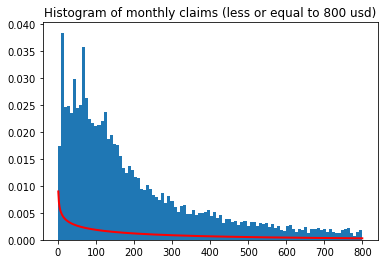

In [933]:
#The seem to be almost the same distribution
plt.hist(claims[claims<=800], 100, weights=weights[claims<=800])
plt.title('Histogram of monthly claims (less or equal to 800 usd)')
plt.plot(dist_pts, gb2_pdf(dist_pts, a_gb2, b_gb2, p_gb2, q_gb2),
         linewidth=2, color='r', label='Generalized beta 2 distribution using MLE')

Again, very similar distribution.

#### Part e) Likelihood ratio

In [807]:
loglik_h0_1 = log_lik_gamma(claims, alpha_MLE, beta_MLE)
loglik_h0_2 = log_lik_ggamma(claims, alpha_gg, beta_gg, m_gg)
loglik_h1   = log_lik_gb2(claims, a_gb2, b_gb2, p_gb2, q_gb2)
LR_1 = 2*(loglik_h1 - loglik_h0_1)
pval_1 = 1.0 - sts.chi2.cdf(LR_1, 4)
LR_2 = 2*(loglik_h1 - loglik_h0_2)
pval_2 = 1.0 - sts.chi2.cdf(LR_2, 4)

print('Gamma versus GB2:')
print('Likelihood ratio value= ', LR_1)
print('p-value (Chi squared with 4 degrees of freedom) =', pval_1)
print('')
print('Generalized gamma versus GB2:')
print('Likelihood ratio value= ', LR_2)
print('p-value (Chi squared with 4 degrees of freedom) =', pval_2)

Gamma versus GB2:
Likelihood ratio value=  1695.9269229387282
p-value (Chi squared with 4 degrees of freedom) = 0.0

Generalized gamma versus GB2:
Likelihood ratio value=  -1255.3880931622698
p-value (Chi squared with 4 degrees of freedom) = 1.0


#### Part f) Probability of claiming more than $1,000

In [808]:
#Using the GB2 estimation
import scipy.integrate as integrate
#Since I didn't find an existing function for CDF of a GB2 distribution, I integrated over the pdf from 1000 to infinity
quad= integrate.quad(lambda x: gb2_pdf(x, a_gb2, b_gb2, p_gb2, q_gb2), 1000, np.inf)

#this gives two values, the first one is the value of the integral
print('Using the GB2 estimation:', quad[0])

#Probability from GA estimation
print('Using the GA estimation:', 1 - sts.gamma.cdf(1000,alpha_MLE, beta_MLE))


Using the GB2 estimation: 0.15319086224849632
Using the GA estimation: 0.08608228510874971


## 2. MLE estimation of simple macroeconomic model

In [905]:
#Read the MacroSeries.txt file
url_macro = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS2/MacroSeries.txt')
response = requests.get(url_macro,allow_redirects=True)

open('MacroSeries.txt', 'wb').write(response.content)
macroseries = np.loadtxt("MacroSeries.txt",
  # dtype={'names': ('ct', 'kt', 'wt', 'rt'),
   #       'formats': (np.float, np.float, np.float, np.float)},
   delimiter=',', skiprows=0)
macroseries[1:10,]

array([[1.16948678e+07, 7.59507176e+06, 1.16107897e+07, 1.10700906e+00],
       [9.29239424e+06, 8.32373510e+06, 9.22558826e+06, 8.02596228e-01],
       [7.91316454e+06, 6.61379241e+06, 7.85627428e+06, 8.60176106e-01],
       [8.14099418e+06, 5.63213594e+06, 8.08246598e+06, 1.03918305e+00],
       [8.27441356e+06, 5.79429199e+06, 8.21492617e+06, 1.02665514e+00],
       [8.62591578e+06, 5.88925224e+06, 8.56390132e+06, 1.05301073e+00],
       [9.01282040e+06, 6.13943133e+06, 8.94802436e+06, 1.05540782e+00],
       [8.78831989e+06, 6.41480781e+06, 8.72513786e+06, 9.84940386e-01],
       [9.72097169e+06, 6.25502124e+06, 9.65108453e+06, 1.11729699e+00]])

#### Part a) First estimation

In [906]:
def eq3 (wt, kt, alpha): 
    zt = np.log(wt) - (np.log(1-alpha)+(alpha)*np.log(kt))
    return zt

In [907]:
def eq5 (z0, rho, mu):
    z_mean=np.zeros(shape=(100,1))
    z_mean[0] = z0[0]
    for i in range(1, 100):
        z_mean[i] = rho*z0[i-1] + (1-rho)*mu 
    return z_mean

In [908]:
def log_lik_norm(zt, z_mean, sigma): 
    pdf_vals1 = sts.norm.pdf(zt, loc=z_mean, scale=sigma)
    pdf_vals1[pdf_vals1 < 1e-10] = 1e-10
    log_vals = np.log(pdf_vals1)
    log_lik_vals1 = log_vals.sum()
    return log_lik_vals1

In [909]:
def crit1(params, *args):
    alpha, rho, mu, sigma = params
    wt, kt = args

    zt = eq3(wt,kt, alpha)
    z_mean = eq5(zt, mu, rho)
    
    log_lik_vals1 = log_lik_norm(zt, z_mean, sigma)
    neg_log_lik_vals1 = -log_lik_vals1
    return neg_log_lik_vals1

In [910]:
#LOOKING FOR GOOD GUESSES

kt = macroseries[:,1] #Data
wt = macroseries[:,2] #Data

#Alpha = .5 seems like a good first guess
alpha_init = .5

#With this, we can estimate back zt
zt_init = eq3(wt, kt, alpha_init)
#zt_init

We now need with this a guess for rho, mu and sigma

In [920]:
#Let's regress zt on zt-1 to get some estimates using the AR1 model for zt
import pandas as pd
from pandas import Series, DataFrame
AR_init = pd.DataFrame(zt_init)
AR_init[1]=AR_init.shift(1)
AR_init[1:99][0]
reg1 = sts.linregress(AR_init[1:99][0],AR_init[1:99][1])

#From this regressions, and equation 5 we can parametrically estimate better initial guesses
rho_init = reg1.slope
mu_init = reg1.intercept / (1-rho_init)
sigma_init = reg1.stderr

In [921]:
#The minimization problem
params_init1 = np.array([alpha_init, rho_init, mu_init, sigma_init])
mle_args1 = (wt, kt)
                    
#Set the bound of alpha on 9999 otherwise it can break
results_macro1 = opt.minimize(crit1, params_init1, args=(mle_args1),
                              method='L-BFGS-B', bounds=((1e-10, .9999), (-1, 1),(1e-10, None), (1e-10, None)))

alpha_est1, rho_est1, mu_est1, sigma_est1 = results_macro1.x
vcv1 = results_macro1.hess_inv.matmat(np.eye(4))  #Taken from an issue resolved in StructEst_W17 (https://github.com/rickecon/StructEst_W17/issues/26)
print('Alpha= ', alpha_est1)
print('Rho= ', rho_est1) 
print('Mu= ', mu_est1)
print('Sigma= ', sigma_est1)
print('Log-likelihood= ',
      log_lik_norm(eq3 (wt, kt, alpha_est1), eq5 (eq3(wt,kt,alpha_est1), rho_est1, mu_est1), sigma_est1))
print('VCV= ', vcv1)

Alpha=  0.7991194260889369
Rho=  0.6800470000537931
Mu=  8.925596060314854
Sigma=  0.10687701329505861
Log-likelihood=  -227874.2089124526
VCV=  [[ 2.20731682e-03  0.00000000e+00  0.00000000e+00 -4.84570705e-07]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-4.84570705e-07  0.00000000e+00  0.00000000e+00  5.62303833e-05]]


#### Part b) Second estimation

In [923]:
def eq4(rt, kt, alpha): 
    zt = np.log(rt) - (np.log(alpha)+(alpha-1)*np.log(kt))
    return zt

In [924]:
def crit2(params, *args):
    alpha, rho, mu, sigma = params
    rt, kt = args

    zt = eq4(rt,kt, alpha)
    z_mean = eq5(zt, mu, rho)
    
    log_lik_vals2 = log_lik_norm(zt, z_mean, sigma)
    neg_log_lik_vals2 = -log_lik_vals2
    return neg_log_lik_vals2

In [926]:
#The minimization problem
kt = macroseries[:,1]
rt = macroseries[:,3]

#Using the same initial guesses from the previous problem
#params_init1 = np.array([alpha_init, rho_init, mu_init, sigma_init])

mle_args2 = (rt, kt)

results_macro2 = opt.minimize(crit2, params_init1, args=(mle_args2), 
                             method='L-BFGS-B', bounds=((1e-10, .9999), (-1, 1),(1e-10, None), (1e-10, None)))
alpha_est2, rho_est2, mu_est2, sigma_est2 = results_macro2.x
vcv2 = results_macro2.hess_inv.matmat(np.eye(4))

print('Alpha= ', alpha_est2)
print('Rho= ', rho_est2) 
print('Mu= ', mu_est2)
print('Sigma= ', sigma_est2)
print('Log-likelihood= ',
      log_lik_norm(eq4 (rt, kt, alpha_est2), eq5 (eq4(rt,kt,alpha_est2), rho_est2, mu_est2), sigma_est2))
print('VCV= ', vcv2)

Alpha=  0.7991194260889369
Rho=  0.6800470000537931
Mu=  8.925596060314854
Sigma=  0.10687701329505861
Log-likelihood=  -227874.2089124526
VCV=  [[ 2.20731682e-03  0.00000000e+00  0.00000000e+00 -4.84570705e-07]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-4.84570705e-07  0.00000000e+00  0.00000000e+00  5.62303833e-05]]


#### Part c) Probability of interest rate greater than 1

In [927]:
#Define z_star from equation 4
z_star= np.log(1) - (np.log(alpha_est1)+(alpha_est1-1)*np.log(7500000))

#Define z_mean from equation 5
z_mean_star = rho_est1 * 10 + (1-rho_est1) * mu_est1
z_star

3.4042674398372053

The probability of the interest rate being greater than 1. 
In other words, the probability of seeing a zt greater than z_star is: 
$$ Pr(z_t>=z^*)$$

In [928]:
sts.norm.cdf(z_star, loc=z_mean_star, scale=sigma_est1)

0.0